In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import ROOT
from ROOT import TH1F, TF1, TCanvas
import uproot
import iminuit
import probfit
%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
def smooth(x, window_len=11, window="hanning"):
    # if x.ndim != 1:
    #     raise ValueError("smooth only accepts 1 dimension arrays.")

    # if x.size < window_len:
    #     raise ValueError("Input vector needs to be bigger than window size.")

    # if window_len < 3:
    #     return x

    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]
    # print(len(s))
    if window == "flat":  # moving average
        w = np.ones(window_len)
    else:
        w = eval("np." + window + "(window_len)")

    y = signal.convolve(s, w / w.sum(), mode="same")

    return y

In [3]:
!ls

muon_decay.ipynb	root_converter.ipynb
muon_decay_total.ipynb	single_analysis_test.ipynb


In [4]:
rel_path = "../../Labs/muon_decay/"
filename = rel_path + "oscil_191216.root"

# filename = rel_path + "mudecays824.root"

In [5]:
# df = RDataFrame("tree",filename)

In [6]:
# df_np = RDataFrame("tree",filename).AsNumpy()
# df_np["channel1"].size

In [7]:
# raw_data = df_np["channel1"][1169]
# n_per_event = raw_data.size()
# timesteps = np.arange(0,n_per_event,1)
# raw_data *= -1.0

In [8]:
df_np = uproot.open(filename)["t1"].array("channel1")
n_events = df_np.size
n_per_event = df_np[0].size
timesteps = np.arange(0,n_per_event,1)
print(f"Number of events: {n_events}")

Number of events: 9032


In [9]:
# mins = []
# for m in(df_np):
#     mins.append(np.min(m))
# np.min(mins)

In [10]:
raw_data = np.negative(df_np[511])
# raw_data = np.negative(df_np[68])

In [46]:
# smoothed_data = smooth(raw_data, window_len=51, window='bartlett')
smoothed_data = signal.savgol_filter(raw_data, 51, 3)
data = np.concatenate((timesteps[:,np.newaxis], smoothed_data[:n_per_event ,np.newaxis]), axis=1)
peak_range = [0.2, data[: ,1].max() ]
peaks, properties = signal.find_peaks(data[: ,1], height=peak_range,distance=300)
# peaks, properties = signal.find_peaks(raw_data, height=peak_range,distance=300)
results_w = signal.peak_widths(data[: ,1], peaks, rel_height=0.95)

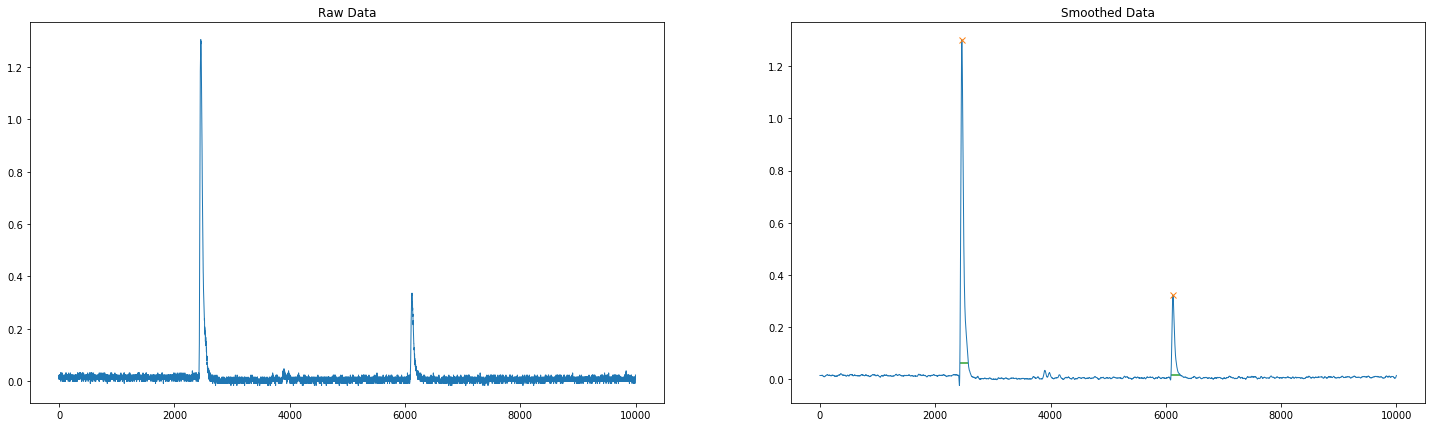

In [47]:
plt.figure(figsize=(25,7))
plt.subplot(121)
plt.plot(timesteps, raw_data, '-', lw=1)
plt.title("Raw Data")
plt.subplot(122)
plt.plot(data[:,0], data[:,1],'-', lw=1)
plt.plot(peaks, data[:,1][peaks], "x")
plt.hlines(*results_w[1:], color="C2")
plt.title("Smoothed Data")
plt.show()

In [43]:
print(f'Peaks width: {results_w[0]}')
for i in range(results_w[1:][0].size):
    print(f'Found peak in range: {results_w[2][i]}, {results_w[3][i]}')
print(f"Found peaks at indices {peaks} with amplitude: {data[peaks,1]}")

Peaks width: [145.46072565 162.50138748]
Found peak in range: 2427.3022984052773, 2572.7630240564376
Found peak in range: 6089.486377363483, 6251.987764842011
Found peaks at indices [2461 6124] with amplitude: [1.30155134 0.32216939]


In [14]:
[int(p) for p in (results_w[2])]

[2427, 6089]

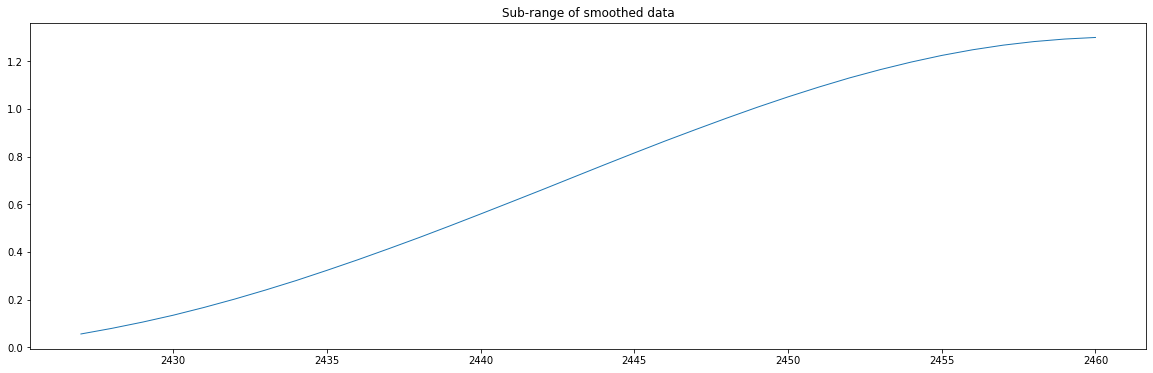

In [15]:
a = int(min(results_w[2]))
ranged_sm_data = data[a:peaks[0]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,0], ranged_sm_data[:,1],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

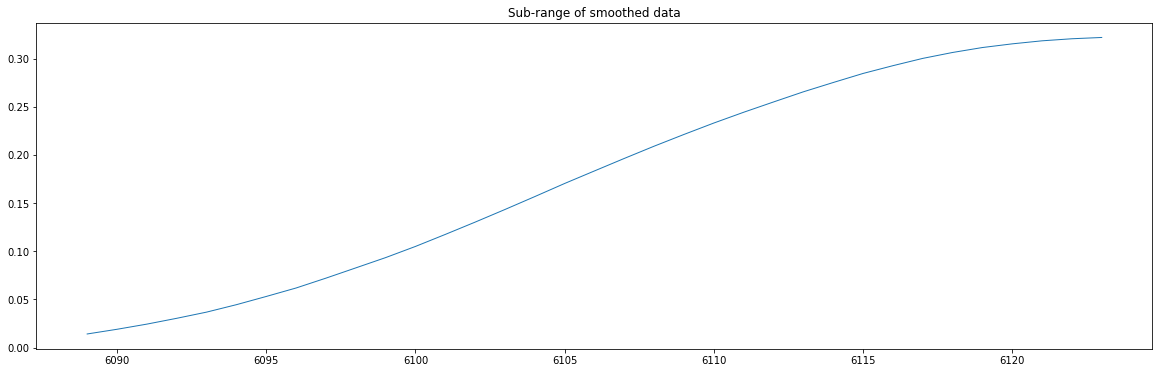

In [16]:
b = int((results_w[2][1]))
# print(b,peaks[1])
ranged_sm_data = data[b:peaks[1]]
plt.figure(figsize=(20,6))
plt.plot(ranged_sm_data[:,0], ranged_sm_data[:,1],'-', lw=1)
plt.title("Sub-range of smoothed data")
plt.show()

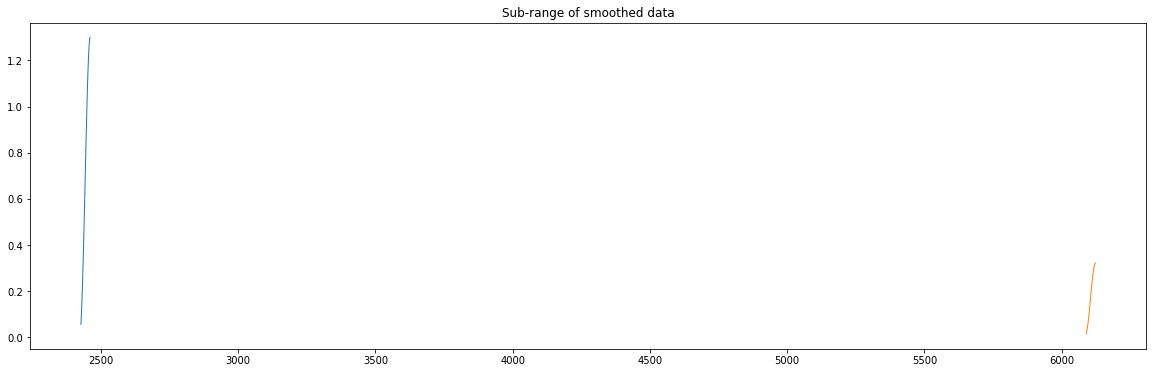

In [17]:
plt.figure(figsize=(20,6))
for min_t, peak in zip(results_w[2], peaks):
    min_t = int(min_t)
    ranged_sm_data = data[min_t:peak]
    plt.plot(ranged_sm_data[:,0], ranged_sm_data[:,1],'-', lw=1)
    plt.title("Sub-range of smoothed data")
plt.show()

# Fitting 1st peak

In [18]:
# We want to speed things up with Cython
%load_ext Cython

In [19]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def sigmoid(double x, double p0, double p1, double p2, double p3):
    return p0 / (1.0 + exp(-1.0 * p2 * (x - p1) ) ) + p3


# def sigmoid(x, p0, p1, p2, p3):
#     return p0 / (1.0 + np.exp(-1.0 * p2 * (x - p1))) + p3


In [20]:
# iminuit.describe(sigmoid)
t1 = np.arange(0, data[a : peaks[0], 0].size)

In [21]:
chi2_fit = probfit.Chi2Regression(
    sigmoid,
    data[a : peaks[0], 0],
#     t1,
    data[a : peaks[0], 1],
)

minuit = iminuit.Minuit(
                chi2_fit,
                p0=np.max(data[a : peaks[0], 1]),
                p1=np.mean(data[a: peaks[0], 0]),
                p3=np.min(data[a : peaks[0], 1]),
#                 limit_p3=(np.min(data[a : peaks[0], 1]), None),
                pedantic=False,
                print_level=1,
            )
minuit.migrad()
try:
    minuit.hesse()
except Exception as e:
    print(str(e))
# iminuit.describe(chi2_fit)

------------------------------------------------------------------
| FCN = 0.001251                |     Ncalls=118 (118 total)     |
| EDM = 9.81E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

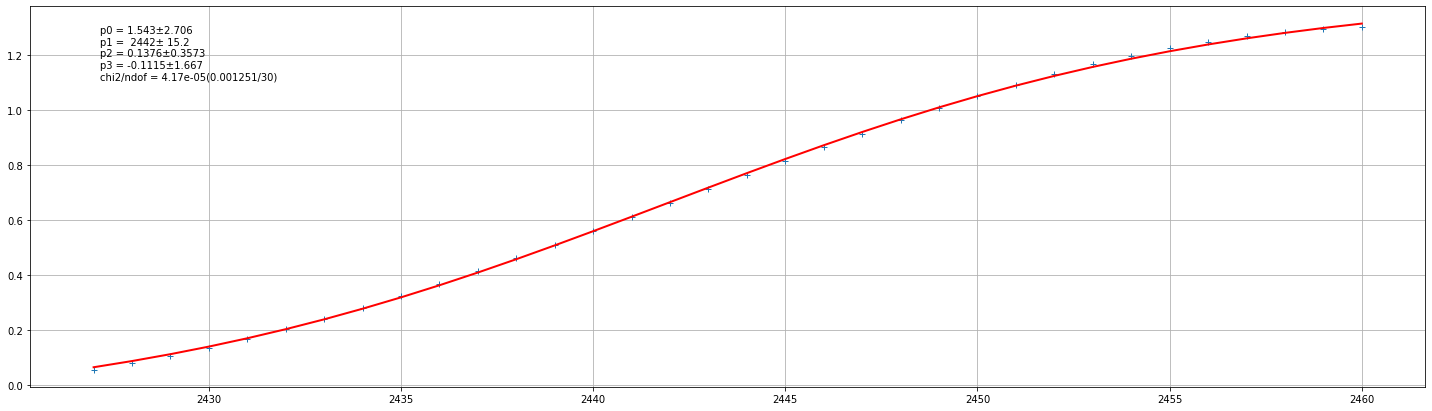

In [22]:
plt.figure(figsize=(25, 7))
chi2_fit.draw(minuit)
plt.show()

In [23]:
p = minuit.values
tz1 = p[1] - np.log(p[0] / (0.2 * data[a : peaks[0] + 1, 1].max() - p[3]) - 1.0) / p[2]
tr1 = tz1 + data[a, 0]
print(tz1, tr1)

2433.5838332789867 4860.583833278986


In [24]:
print(minuit.values)
print(minuit.errors)

<ValueView of Minuit at 557f585a2970>
  p0: 1.5428009527704734
  p1: 2441.922245433233
  p2: 0.13758835578064207
  p3: -0.11148682038273033
<ErrorView of Minuit at 557f585a2970>
  p0: 2.706001971043868
  p1: 15.203667737669713
  p2: 0.3573413380286754
  p3: 1.6672688707205328


In [25]:
print(f'The value of the variable p0 is {minuit.values["p0"]}') 
print(f'The value of the variable p1 is {minuit.values["p1"]}') 
print(f'The value of the variable p2 is {minuit.values["p2"]}') 
print(f'The value of the variable p3 is {minuit.values["p3"]}') 

The value of the variable p0 is 1.5428009527704734
The value of the variable p1 is 2441.922245433233
The value of the variable p2 is 0.13758835578064207
The value of the variable p3 is -0.11148682038273033


## Fitting second peak

------------------------------------------------------------------
| FCN = 0.0001023               |     Ncalls=161 (161 total)     |
| EDM = 3.87E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

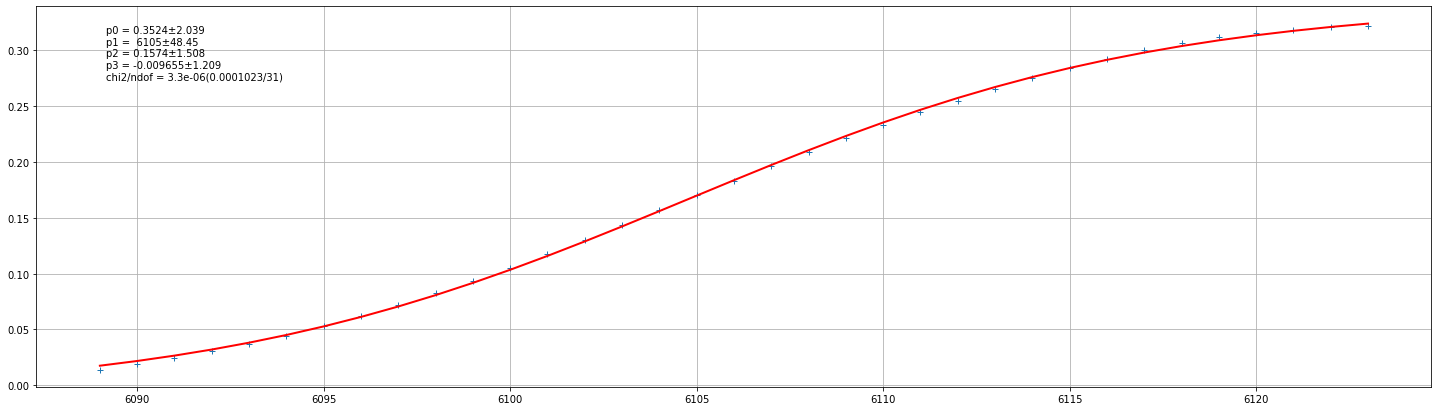

In [26]:
t2 = np.arange(0, data[b : peaks[1], 0].size)
chi2_fit_p2 = probfit.Chi2Regression(
    sigmoid,
    data[b : peaks[1], 0],
#     t2,
    data[b : peaks[1], 1],
)

minuit_p2 = iminuit.Minuit(
                chi2_fit_p2,
#                 p0=np.max(data[b : peaks[1], 1]),
#                 limit_p1=(data[b, 0], np.mean(data[b : peaks[1], 0])),
                p1=np.mean(data[b : peaks[1], 0]),
                p3=np.min(data[b : peaks[1], 1]),
#                 limit_p3=(np.min(data[b : peaks[1], 1]), None),
#                 fix_p3=np.min(data[b : peaks[1], 1]),
                pedantic=False,
                print_level=1,
            )

minuit_p2.migrad()
try:
    minuit_p2.hesse()
except Exception as e:
    print(str(e))

plt.figure(figsize=(25, 7))
chi2_fit_p2.draw(minuit_p2)
plt.show()
# iminuit.describe(sigmoid)

In [27]:
print(f'The value of the variable p0 is {minuit_p2.values["p0"]}') 
print(f'The value of the variable p1 is {minuit_p2.values["p1"]}') 
print(f'The value of the variable p2 is {minuit_p2.values["p2"]}') 
print(f'The value of the variable p3 is {minuit_p2.values["p3"]}') 

The value of the variable p0 is 0.3524084022211614
The value of the variable p1 is 6104.765489226461
The value of the variable p2 is 0.15737353731704393
The value of the variable p3 is -0.009655487960958428


In [28]:
pp = minuit_p2.values
tz2 = pp[1] - np.log(pp[0] / (0.2 * data[b : peaks[1], 1].max() - pp[3]) - 1) / pp[2]
tr2 = tz2 + data[b, 0]
print(tz2, tr2)

6096.349012604885 12185.349012604886


In [29]:
np.mean(data[a: peaks[0], 0])

2443.5

## Trying ROOT fitting because iminuit doesnt like that data

In [30]:

sg = """
Double_t sig_cpp(Double_t *x, Double_t *par)
{
  return par[0] / (1.0 + TMath::Exp(-par[2] * (x[0] - par[1]))) + par[3];
};
"""
ROOT.gInterpreter.Declare(sg)

True

 FCN=0.00110382 FROM MIGRAD    STATUS=CONVERGED     462 CALLS         463 TOTAL
                     EDM=2.51603e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.60238e+00   2.27049e+00   1.29466e-04   1.17575e-03
   2  p1           2.44232e+03   1.11968e+01   1.38466e-03  -3.45076e-05
   3  p2           1.30859e-01   2.76487e-01   2.00514e-05   4.53695e-03
   4  p3          -1.45981e-01   1.06948e+00   4.86394e-05   6.80248e-04


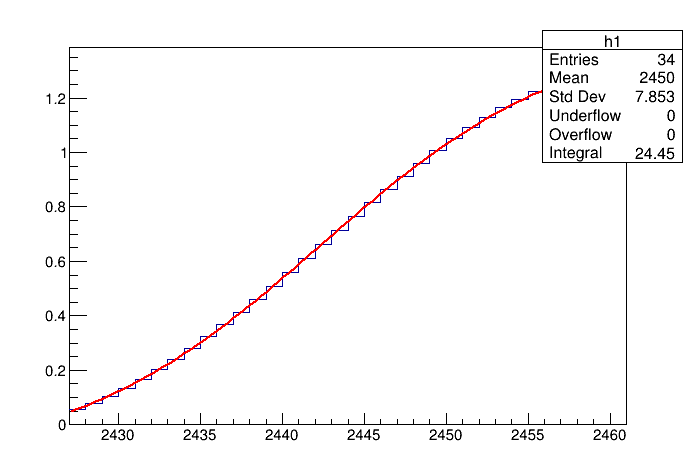

In [31]:
ROOT.gStyle.SetOptStat(1111111)
c1 = TCanvas()
hist_p1 = TH1F("h1"," ", data[a : peaks[0], 0].size, data[a, 0], data[peaks[0], 0])
for i, vt in enumerate(data[a : peaks[0], 1]):
    hist_p1.SetBinContent(hist_p1.GetBin(i + 1), vt)

g1 = TF1("g1", ROOT.sig_cpp, data[a, 0], data[peaks[0], 0], 4)
g1.SetParameter(1, np.mean(data[a: peaks[0], 0]))
hist_p1.Fit(g1, "R")
hist_p1.Draw("same")
c1.Draw()

 FCN=0.000181899 FROM MIGRAD    STATUS=CONVERGED     391 CALLS         392 TOTAL
                     EDM=5.35056e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.70582e-01   8.07772e-01   6.46565e-05  -6.01531e-03
   2  p1           6.10509e+03   1.92803e+01   2.91113e-03   7.64284e-05
   3  p2           1.45456e-01   5.11742e-01   4.70818e-05  -3.56271e-03
   4  p3          -2.06957e-02   3.58899e-01   2.34863e-05  -8.65513e-03


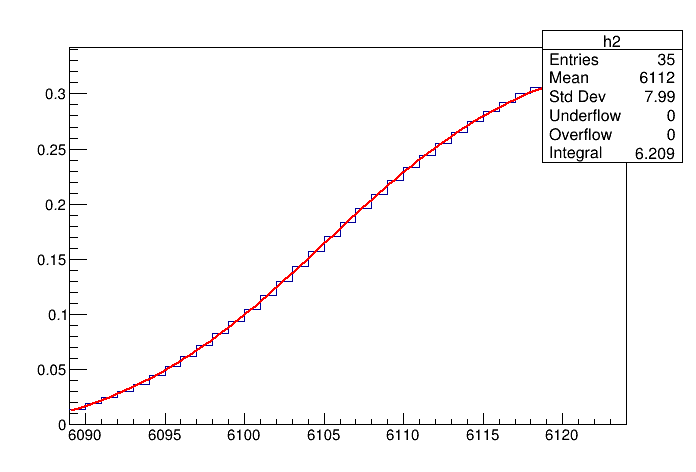

In [32]:
ROOT.gStyle.SetOptStat(1111111)
c1 = TCanvas()
hist_p2 = TH1F("h2"," ", data[b : peaks[1], 0].size, data[b, 0], data[peaks[1], 0])
for i, vt in enumerate(data[b : peaks[1], 1]):
    hist_p2.SetBinContent(hist_p2.GetBin(i + 1), vt)

g2 = TF1("g2", ROOT.sig_cpp, data[b, 0], data[peaks[1], 0], 4)
g2.SetParameter(1, np.mean(data[b: peaks[1], 0]))
hist_p2.Fit(g2, "R")
hist_p2.Draw("same")
c1.Draw()

## whatever stuf

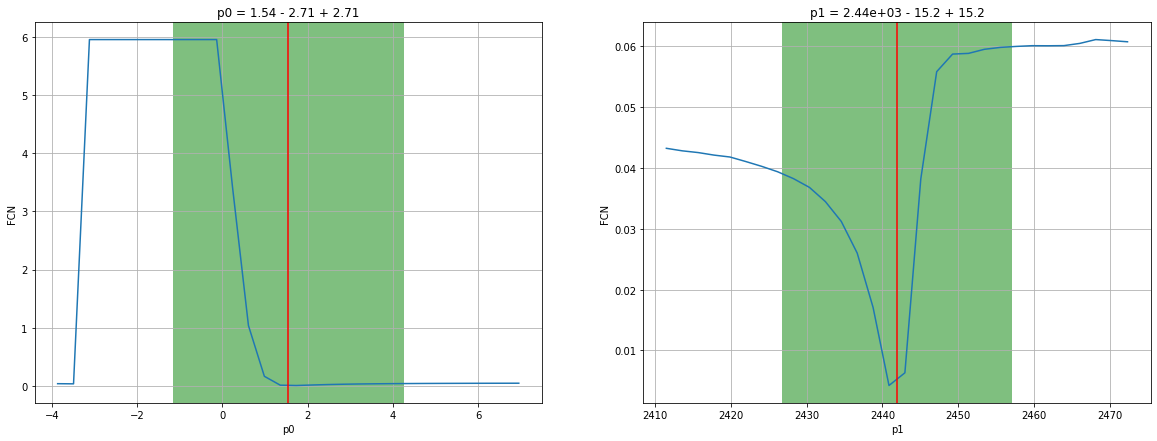

In [33]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p0')
plt.subplot(122)
minuit.draw_mnprofile('p1')
plt.show()

/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=1.383306
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=1.843242
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=2.303178
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=2.533147
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=2.763115
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=2.993083
  """
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Migrad fails to converge for p3=3.223051
  """


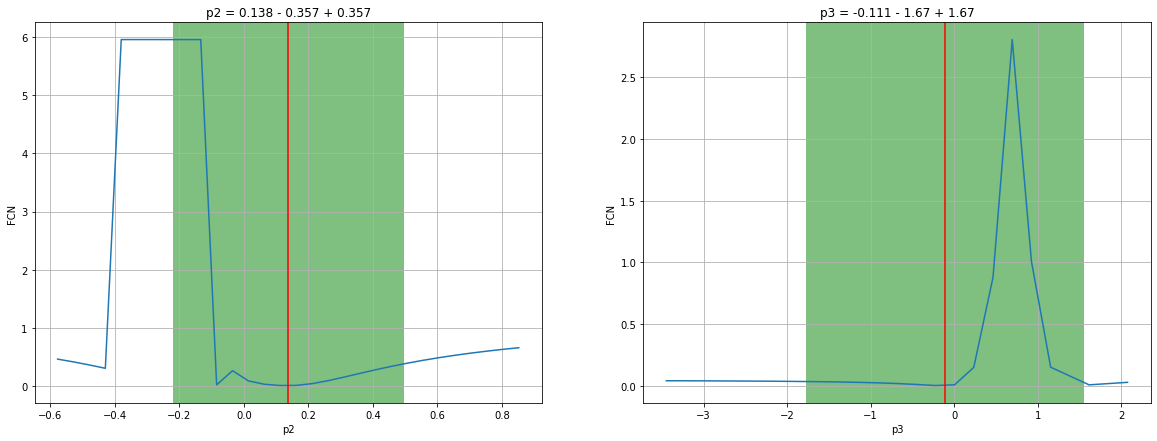

In [34]:
plt.figure(figsize=(20,7))
plt.subplot(121)
minuit.draw_mnprofile('p2')
plt.subplot(122)
minuit.draw_mnprofile('p3')
plt.show()

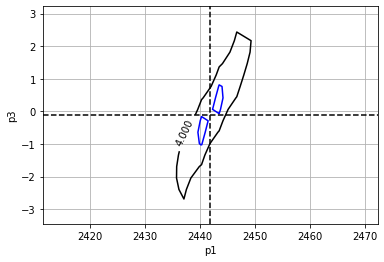

In [35]:
minuit.draw_contour('p1', 'p3')
plt.show()